In [6]:
# input model from Bertram et al., 2004

from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import numpy as np


import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")


def Bertram2004(t,x, Rgk = 0.01, gkatpbar=25000):
    # set up variable vectors
    v=x[0]; n=x[1]; c=x[2]; adp=x[3]; cer=x[4]; g6p=x[5]; fbp=x[6];
    
    
    # voltage module
    gkca=600; gk=2700; gca=1000; vca=25;cm=5300; kd=0.5; taun=20; vk = -75;

    minf = 1/(1+np.exp(-(20+v)/12));
    ninf = 1/(1+np.exp(-(16+v)/5));
    ikca = gkca/(1+(kd/c)**2)*(v-vk);
    ica = gca*minf*(v-vca);
    ik = gk*n*(v-vk);
    
    # calcium module
    alpha=4.5e-6; kpmca=0.2; pleak=0.0002;   fcyt=0.01; fer=0.01; kserca = 0.4;
    Jmem = -(alpha*ica + kpmca*c);
    Jserca = kserca*c;
    Jleak = pleak*(cer - c);
    Jer = (Jleak - Jserca);
    
    # nucleotide concentrations
    atot = 3000;
    rad = np.sqrt( (atot-adp)*(atot-adp) - 4*adp*adp );
    atp = 0.5*(atot-adp+rad);
    amp = adp * adp/ atp;
    
    f6p = 0.3*g6p;
    Rgpdh = 0.2*np.sqrt(fbp);
    
    
    # glycolysis
    lambda1=0.005; # convert glycolysis model time scale from Smolen 1995.
    k1=30; k2=1; k3=50000; k4=1000;
    famp=0.02; fatp=20; ffbp=0.2; fbt=20; fmt=20;
    pfkbas=0.06; cat=2; katpase=0.0003;
    # Iterative calculation of PFK
    #    alpha=1 -- AMP bound
    #    beta=1 -- FBP bound
    #    gamma=1 -- F6P bound
    #    delta=1 -- ATP bound
    # (alpha,beta,gamma,delta)
    # (0,0,0,0)
    weight1=1; topa1=0; bottom1=1;
    # (0,0,0,1)
    weight2=atp**2/k4; topa2=topa1; bottom2=bottom1+weight2;
    # (0,0,1,0)
    weight3=f6p**2/k3;
    topa3=topa2+weight3;
    bottom3=bottom2+weight3;
    # (0,0,1,1)
    weight4=(f6p*atp)**2/(fatp*k3*k4);
    topa4=topa3+weight4;
    bottom4=bottom3+weight4;
    # (0,1,0,0)
    weight5=fbp/k2;
    topa5=topa4;
    bottom5=bottom4+weight5;
    # (0,1,0,1)
    weight6=(fbp*atp**2)/(k2*k4*fbt);
    topa6=topa5;
    bottom6=bottom5+weight6;
    # (0,1,1,0)
    weight7=(fbp*f6p**2)/(k2*k3*ffbp);
    topa7=topa6+weight7;
    bottom7=bottom6+weight7;
    # (0,1,1,1)
    weight8=(fbp*f6p**2*atp**2)/(k2*k3*k4*ffbp*fbt*fatp);
    topa8=topa7+weight8;
    bottom8=bottom7+weight8;
    # (1,0,0,0)
    weight9=amp/k1;
    topa9=topa8;
    bottom9=bottom8+weight9;
    # (1,0,0,1)
    weight10=(amp*atp**2)/(k1*k4*fmt);
    topa10=topa9;
    bottom10=bottom9+weight10;
    # (1,0,1,0)
    weight11=(amp*f6p**2)/(k1*k3*famp);
    topa11=topa10+weight11;
    bottom11=bottom10+weight11;
    # (1,0,1,1)
    weight12=(amp*f6p**2*atp**2)/(k1*k3*k4*famp*fmt*fatp);
    topa12=topa11+weight12;
    bottom12=bottom11+weight12;
    # (1,1,0,0)
    weight13=(amp*fbp)/(k1*k2);
    topa13=topa12;
    bottom13=bottom12+weight13;
    # (1,1,0,1)
    weight14=(amp*fbp*atp**2)/(k1*k2*k4*fbt*fmt);
    topa14=topa13;
    bottom14=bottom13+weight14;
    # (1,1,1,0) -- the most active state of the enzyme
    weight15=(amp*fbp*f6p**2)/(k1*k2*k3*ffbp*famp);
    topa15=topa14;
    topb=weight15;
    bottom15=bottom14+weight15;
    # (1,1,1,1)
    weight16=(amp*fbp*f6p**2*atp**2)/(k1*k2*k3*k4*ffbp*famp*fbt*fmt*fatp);
    topa16=topa15+weight16;
    bottom16=bottom15+weight16;
    
    #Phosphofructokinase rate
    pfk=(pfkbas*cat*topa16 + cat*topb)/bottom16;
    
    
    # K_ATP channel
    # gkatpbar=25000; 
    kdd=17; ktt=1; ktd = 26; 
    mgadp = 0.165*adp; adp3m = 0.135*adp; atp4m = 0.05*atp;
    topo = 0.08*(1+2*mgadp/kdd) + 0.89*(mgadp/kdd) *(mgadp/kdd);
    bottomo = (1+mgadp/kdd)**2 * (1+adp3m/ktd+atp4m/ktt);
    katpo = topo/bottomo;
    ikatp = gkatpbar*katpo*(v-vk);
    
    # glycolytic input to adp
    r = 1;  vg = 2.2; kg = 10; r1 = 0.35; taua = 3e5;
    y = vg*(Rgpdh/(kg+Rgpdh));
    fback = r+y;
    
    sigmav = 31;


    vdot = -(ik + ica + ikca + ikatp)/cm;
    ndot = (ninf - n)/taun;
    cdot = fcyt*(Jmem + Jer);
    adpdot = (atp-adp*np.exp(fback*(1-c/r1)))/taua;
    cerdot = -fer*sigmav*Jer;
    g6pdot = lambda1*(Rgk - pfk);
    fbpdot = lambda1*(pfk - 0.5*Rgpdh);


    dxdt=[vdot, ndot, cdot, adpdot, cerdot, g6pdot, fbpdot];
    
    return dxdt


In [7]:
def KATPscan(Rgk = 0.01, gkatpbar = 25000, pretime = 2, posttime = 10, init = [-60.3, 1.4e-4, 0.0644, 808.5, 128.803, 206.718, 0.0098]):
    # do a pre-equiliration on the data
    tmp1 = solve_ivp(lambda t,y: Bertram2004(t,y, 0.01, gkatpbar), (0, 1000*60*30), init) # pre-fix the equilibrium time at 30min
    init1 = [tmp1.y[0][-1], tmp1.y[1][-1], tmp1.y[2][-1], tmp1.y[3][-1], tmp1.y[4][-1], tmp1.y[5][-1], tmp1.y[6][-1]]
    # run a pre-time selection
    pre = solve_ivp(lambda t,y: Bertram2004(t,y, 0.01, gkatpbar), (0, 1000*60*pretime), init1)

    pre1 = solve_ivp(lambda t,y: Bertram2004(t,y, 0.01, gkatpbar), (0, 1000*60*1), init1)
    init11 = [pre1.y[0][-1], pre.y[1][-1], pre.y[2][-1], pre.y[3][-1], pre.y[4][-1], pre.y[5][-1], pre.y[6][-1]]
    pre2 = solve_ivp(lambda t,y: Bertram2004(t,y, 0.01, gkatpbar), (0, 1000*60*1), init11)

    cal_by_minute = []
    cal_by_minute.append(np.mean(pre1.y[2]/np.min(pre.y[2]))) # the first minute before stimulation
    cal_by_minute.append(np.mean(pre2.y[2]/np.min(pre.y[2]))) # the second minute before stimulation

    
    init2 = [pre.y[0][-1], pre.y[1][-1], pre.y[2][-1], pre.y[3][-1], pre.y[4][-1], pre.y[5][-1], pre.y[6][-1]]
    # first minute of post-stimulation
    post = solve_ivp(lambda t,y: Bertram2004(t,y, Rgk, gkatpbar), (0, 1000*60*1), init2)
    del init2
    
    # run the post time simulation, minute by minute
    i = 0
    while i<posttime:
        init2 = [post.y[0][-1], post.y[1][-1], post.y[2][-1], post.y[3][-1], post.y[4][-1], post.y[5][-1], post.y[6][-1]]
        tmppost = solve_ivp(lambda t,y: Bertram2004(t,y, Rgk, gkatpbar), (0, 1000*60*1), init2)
        
        post.t = np.concatenate( ( post.t, tmppost.t + post.t[-1] ), axis = 0 ) # unit in ms
        post.y = np.concatenate( (post.y, tmppost.y), axis = 1 )

        cal_by_minute.append(np.mean(tmppost.y[2]/np.min(pre.y[2])))
        del init2, tmppost
        
        i = i+1
        
    # combine all the data

    res = pre
    
    res.t = np.concatenate( (pre.t - pre.t[-1], post.t), axis = 0 )/(1000 * 60) # convert into min
    res.y = np.concatenate( (pre.y, post.y), axis = 1 )
    # normalized calcium concentration
    res.norcal = res.y[2]/np.min(pre.y[2])
    # save the original calcium concentration
    res.cal = res.y[2]
    
    return res, cal_by_minute

## scan how KATP conductance changes basal membrane potential


In [ ]:
def BasalPotential(Rgk = 0.01, gkatpbar = 25000, pretime = 10, posttime = 2, init = [-60.3, 1.4e-4, 0.0644, 808.5, 128.803, 206.718, 0.0098]):
   
    tmp1 = solve_ivp(lambda t,y: Bertram2004(t,y, Rgk, gkatpbar), (0, 1000*60*pretime), init)
    init1 = [tmp1.y[0][-1], tmp1.y[1][-1], tmp1.y[2][-1], tmp1.y[3][-1], tmp1.y[4][-1], tmp1.y[5][-1], tmp1.y[6][-1]]
    
    pre = solve_ivp(lambda t,y: Bertram2004(t,y, Rgk, gkatpbar), (0, 1000*60*posttime), init1)
    
    time = pre.t
    
    voltage = pre.y[0]
    
    calcium = pre.y[2]
    
    return time, voltage, calcium

In [74]:
gkatpbar = [20, 24, 25, 30, 40]

time = []
voltage = []
calcium = []

for katpbar in gkatpbar:
    t, v, c = BasalPotential(gkatpbar = katpbar*1000) # convert ns into ps
    t = t/1000
    time.append(t.tolist())
    voltage.append(v.tolist())
    calcium.append(c.tolist())
    del v,c, t

Text(0, 0.5, 'membrane voltage (mV)')

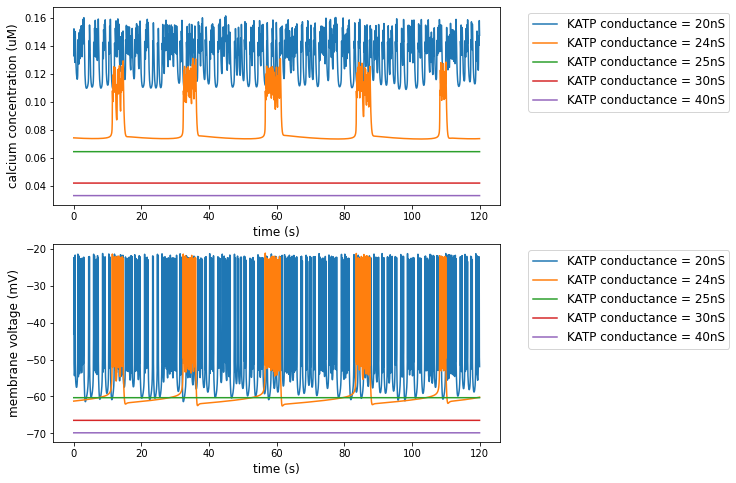

In [76]:
plt.figure(figsize = (8,8))

plt.subplot(211)

for i in range(len(gkatpbar)):
    plt.plot(time[i], calcium[i], label = 'KATP conductance = '+ str(gkatpbar[i]) + 'nS')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize = 12)
plt.xlabel('time (s)', fontsize = 12)
plt.ylabel('calcium concentration (uM)', fontsize = 12)


plt.subplot(212)

for i in range(len(gkatpbar)):
    plt.plot(time[i], voltage[i], label = 'KATP conductance = ' + str(gkatpbar[i]) + 'nS')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize = 12)
plt.xlabel('time (s)', fontsize = 12)
plt.ylabel('membrane voltage (mV)', fontsize = 12)

Text(0, 0.5, 'cytosolic calcium concentration (uM)')

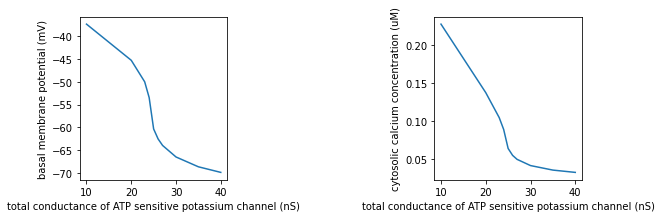

In [64]:
final_voltage = []
final_calcium = []

gkatpbar = [10, 20, 23, 24, 25, 30, 35, 40]


for katpbar in gkatpbar:
    time, v, c = BasalPotential(gkatpbar = katpbar*1000) # convert ns into ps
    final_voltage.append(np.mean(v))
    final_calcium.append(np.mean(c))
    del v,c, time

plt.figure(figsize = (9,3))

plt.subplot(131)
plt.plot(gkatpbar, final_voltage)
plt.xlabel('total conductance of ATP sensitive potassium channel (nS)')
plt.ylabel('basal membrane potential (mV)')


plt.subplot(133)
plt.plot(gkatpbar, final_calcium)
plt.xlabel('total conductance of ATP sensitive potassium channel (nS)')
plt.ylabel('cytosolic calcium concentration (uM)')


## see how conductance of ATP-sensitive potassium channel changes 

In [35]:
np.random.seed(0)

def MultipleSimulation(Rgk = 1, gkatpbar_mean = 25, gkatpbar_stdev = 2, SimulationSize = 40):
    N = SimulationSize # the time of simulation being run; minimal 30
    
    gkatp2 = np.random.normal(gkatpbar_mean, gkatpbar_stdev, N)

    calc2 = np.zeros((12, N))

    for i in range(N):
        _, calmintmp = KATPscan(Rgk = 1, gkatpbar = gkatp2[i] * 1000, pretime = 2, posttime = 10)
        calc2[:,i] = np.array(calmintmp)

    calc2mean = np.mean(calc2, axis = 1)
    calc2std = np.std(calc2, axis = 1)
    
    return calc2mean, calc2std

calc1mean, calc1std = MultipleSimulation(Rgk = 1, gkatpbar_mean = 25, gkatpbar_stdev = 2, SimulationSize = 50)
calc2mean, calc2std = MultipleSimulation(Rgk = 1, gkatpbar_mean = 29, gkatpbar_stdev = 2, SimulationSize = 50)

print(calc1mean)
print(calc1std)
print(calc2mean)
print(calc2std)

[1.1016697  1.10168873 1.61906377 1.75523547 1.77975465 1.79024466
 1.80026641 1.79490132 1.799799   1.80093907 1.80106216 1.80000983]
[0.11899873 0.12216789 0.19855952 0.17875795 0.17864226 0.17320146
 0.17584253 0.17335576 0.17477118 0.17296209 0.17426825 0.17155772]
[1.00000189 1.00000765 1.33038558 1.50066538 1.56661767 1.58836041
 1.5877386  1.6095019  1.60350155 1.60579544 1.61467289 1.61606253]
[1.55470925e-07 6.15503853e-07 3.00636751e-01 3.18071677e-01
 3.03964303e-01 2.97192597e-01 2.85018305e-01 2.96461756e-01
 2.87383328e-01 2.85917536e-01 2.89956251e-01 2.91604314e-01]


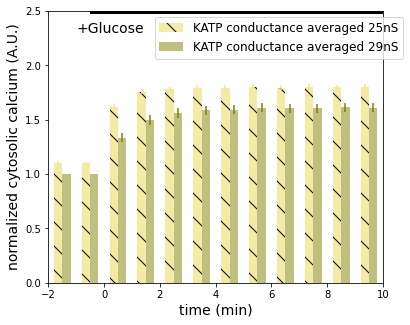

In [25]:
# plot the simulation data 
time = [x-1.5 for x in list(range(12))]
time = np.array(time)

plt.figure(figsize = (6,5))


plt.bar(time-0.15, calc1mean, width = 0.3, color = 'khaki', alpha = 0.8, label = "KATP conductance averaged 25nS", hatch = '\\')
plt.errorbar(time-0.15, calc1mean, calc1std/np.sqrt(50), linestyle = '', color = 'khaki')

plt.bar(time+0.15, calc2mean, width = 0.3, color = 'olive', alpha = 0.5, label = "KATP conductance averaged 29nS")
plt.errorbar(time+0.15, calc2mean, calc2std/np.sqrt(50), linestyle = '', color = 'olive')


plt.xlabel('time (min)', fontsize = 14), plt.ylabel('normalized cytosolic calcium (A.U.)', fontsize = 14)
plt.bar(np.array(range(0, 12, 1)), height = 0.1, width = 1, bottom = 2.47, color = 'k')
plt.text(-1, 2.3, '+Glucose', fontsize = 14)
plt.ylim([0, 2.5])
plt.xlim([-2, 10]) 
plt.legend(fontsize = 12, bbox_to_anchor=(0.3, 1), loc='upper left')

plt.show()

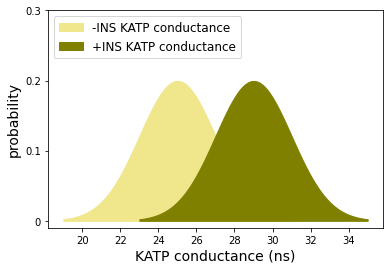

In [105]:
# plot histograms of KATP conductance distribution
import scipy.stats as stats

x1 = np.linspace(25 - 6, 25 + 6, 200)
x2 = np.linspace(29 - 6, 29 + 6, 200)

y1 = stats.norm.pdf(x1, 25, 2)
y2 = stats.norm.pdf(x2, 29, 2)

fig, ax = plt.subplots()

ax.fill_between(x1, y1,  color = 'khaki', label = '-INS KATP conductance')
ax.fill_between(x2, y2,  color = 'olive', label = '+INS KATP conductance')


#plt.plot(x1, , color = 'khaki', label = '-INS KATP conductance')
#plt.plot(x2, , color = 'olive', label = '+INS KATP conductance')
plt.xlabel('KATP conductance (ns)', fontsize = 14)
plt.ylabel('probability', fontsize = 14)
plt.yticks([0, 0.1, 0.2, 0.3], ['0', '0.1', '0.2', '0.3'])
plt.legend(fontsize = 12, bbox_to_anchor=(0, 1), loc='upper left')

plt.show()

## compare raw calcium concentration and normalized calcium concentration

In [9]:
r1, calmin1 = KATPscan(Rgk = 1, gkatpbar = 25000, pretime = 2, posttime = 10)
r2, calmin2 = KATPscan(Rgk = 2, gkatpbar = 29000, pretime = 2, posttime = 10)
r3, calmin3 = KATPscan(Rgk = 1, gkatpbar = 30000, pretime = 2, posttime = 10)

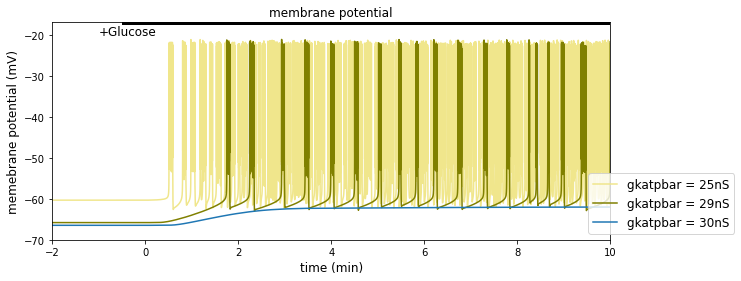

In [34]:
plt.figure(figsize = (10, 4))

plt.plot(r1.t, r1.y[0], label = 'gkatpbar = 25nS', color = 'khaki')
plt.plot(r2.t, r2.y[0], label = 'gkatpbar = 29nS', color = 'olive')
plt.plot(r3.t, r3.y[0], label = 'gkatpbar = 30nS')
plt.title('membrane potential')
plt.xlabel('time (min)', fontsize = 12), plt.ylabel('memebrane potential (mV)', fontsize = 12)
plt.bar(np.array(range(0, 12, 1)), height = 1.9, width = 1, bottom = -17.7, color = 'k')
plt.text(-1, -20, '+Glucose', fontsize = 12)
plt.ylim([-70, -17])
plt.xlim([-2, 10])
plt.legend(fontsize = 12, bbox_to_anchor=(0.95, 0), loc='lower left')
#plt.yticks([0, 0.04, 0.08, 0.12, 0.16], ['0', '0.04', '0.08', '0.12', '0.16'])

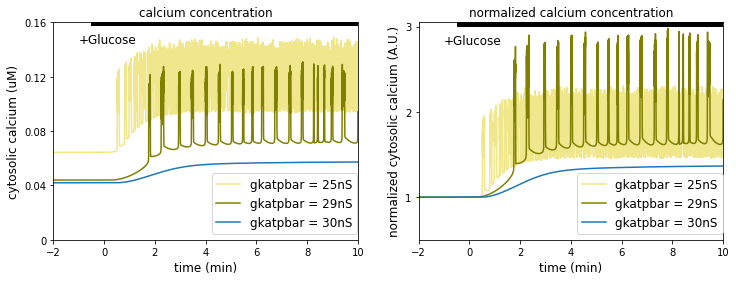

In [10]:
plt.figure(figsize = (12,4))

plt.subplot(121)
plt.plot(r1.t, r1.cal, label = 'gkatpbar = 25nS', color = 'khaki')
plt.plot(r2.t, r2.cal, label = 'gkatpbar = 29nS', color = 'olive')
plt.plot(r3.t, r3.cal, label = 'gkatpbar = 30nS')
plt.title('calcium concentration')
plt.xlabel('time (min)', fontsize = 12), plt.ylabel('cytosolic calcium (uM)', fontsize = 12)
plt.bar(np.array(range(0, 12, 1)), height = 0.1, width = 1, bottom = 0.157, color = 'k')
plt.text(-1, 0.145, '+Glucose', fontsize = 12)
plt.ylim([0, 0.16])
plt.xlim([-2, 10])
plt.legend(fontsize = 12, bbox_to_anchor=(0.5, 0), loc='lower left')
plt.yticks([0, 0.04, 0.08, 0.12, 0.16], ['0', '0.04', '0.08', '0.12', '0.16'])


plt.subplot(122)
plt.plot(r1.t, r1.norcal, label = 'gkatpbar = 25nS', color = 'khaki')
plt.plot(r2.t, r2.norcal, label = 'gkatpbar = 29nS', color = 'olive')
plt.plot(r3.t, r3.norcal, label = 'gkatpbar = 30nS')
plt.title('normalized calcium concentration')
plt.xlabel('time (min)', fontsize = 12), plt.ylabel('normalized cytosolic calcium (A.U.)', fontsize = 12)
plt.bar(np.array(range(0, 12, 1)), height = 0.1, width = 1, bottom = 3, color = 'k')
plt.text(-1, 2.8, '+Glucose', fontsize = 12)
plt.ylim([0.5, 3.05])
plt.xlim([-2, 10])
plt.legend(fontsize = 12, bbox_to_anchor=(0.5, 0), loc='lower left')
plt.yticks([1, 2, 3], ['1', '2', '3'])



plt.show()

Text(0.5, 1.0, 'normalized calcium concentration (by minute)')

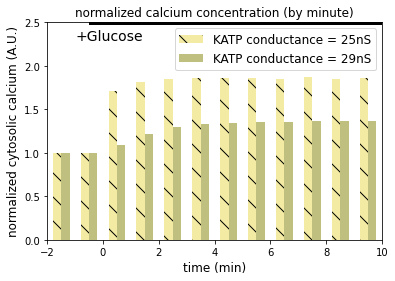

In [99]:
time = [x-1.5 for x in list(range(12))]
time = np.array(time)

plt.bar(time-0.15, calmin1, width = 0.3, color = 'khaki', alpha = 0.8, label = "KATP conductance = 25nS", hatch = '\\')

plt.bar(time+0.15, calmin3, width = 0.3, color = 'olive', alpha = 0.5, label = "KATP conductance = 29nS")


plt.xlabel('time (min)', fontsize = 12), plt.ylabel('normalized cytosolic calcium (A.U.)', fontsize = 12)
plt.bar(np.array(range(0, 12, 1)), height = 0.1, width = 1, bottom = 2.47, color = 'k')
plt.text(-1, 2.3, '+Glucose', fontsize = 14)
plt.ylim([0, 2.5])
plt.xlim([-2, 10]) 
plt.legend(fontsize = 12, loc='upper right')
plt.title('normalized calcium concentration (by minute)')


In [72]:
#r1, calmin1 = KATPscan(Rgk = 1, gkatpbar = 25000, pretime = 2, posttime = 10)
r4, calmin2 = KATPscan(Rgk = 2, gkatpbar = 23000, pretime = 2, posttime = 10)
r5, calmin3 = KATPscan(Rgk = 1, gkatpbar = 20000, pretime = 2, posttime = 10)

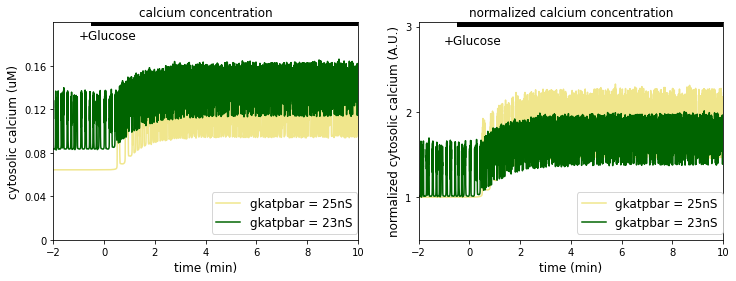

In [89]:
plt.figure(figsize = (12,4))

plt.subplot(121)
plt.plot(r1.t, r1.cal, label = 'gkatpbar = 25nS', color = 'khaki')
plt.plot(r4.t, r4.cal, label = 'gkatpbar = 23nS', color = 'darkgreen')
#plt.plot(r5.t, r5.cal, label = 'gkatpbar = 20nS')
plt.title('calcium concentration')
plt.xlabel('time (min)', fontsize = 12), plt.ylabel('cytosolic calcium (uM)', fontsize = 12)
plt.bar(np.array(range(0, 12, 1)), height = 0.1, width = 1, bottom = 0.197, color = 'k')
plt.text(-1, 0.185, '+Glucose', fontsize = 12)
plt.ylim([0, 0.2])
plt.xlim([-2, 10])
plt.legend(fontsize = 12, bbox_to_anchor=(0.5, 0), loc='lower left')
plt.yticks([0, 0.04, 0.08, 0.12, 0.16], ['0', '0.04', '0.08', '0.12', '0.16'])


plt.subplot(122)
plt.plot(r1.t, r1.norcal, label = 'gkatpbar = 25nS', color = 'khaki')
plt.plot(r4.t, r4.norcal, label = 'gkatpbar = 23nS', color = 'darkgreen')
#plt.plot(r5.t, r5.norcal, label = 'gkatpbar = 20nS')
plt.title('normalized calcium concentration')
plt.xlabel('time (min)', fontsize = 12), plt.ylabel('normalized cytosolic calcium (A.U.)', fontsize = 12)
plt.bar(np.array(range(0, 12, 1)), height = 0.1, width = 1, bottom = 3, color = 'k')
plt.text(-1, 2.8, '+Glucose', fontsize = 12)
plt.ylim([0.5, 3.05])
plt.xlim([-2, 10])
plt.legend(fontsize = 12, bbox_to_anchor=(0.5, 0), loc='lower left')
plt.yticks([1, 2, 3], ['1', '2', '3'])



plt.show()